Use conda environment `conda_envs/cool.yml` to run this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import cooler
import cooltools
from coolpuppy import coolpup
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns
import numpy as np
import bioframe as bf
from IPython.display import Image
from pybedtools import BedTool as pbt
from joblib import Memory
from os import listdir
import re
from itertools import product
from pypdf import PdfMerger
import utils


# Add cache functionality to some functions
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)

expected_cis_cache = memory.cache(cooltools.expected_cis, ignore=['nproc'])
subt_snips_cache = memory.cache(utils.subt_snips, ignore=['print_ct'])

# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)


def plot_av_dot_pca(pup: dict, vmax: float, **subplot_kwargs):

    # get cts from pup
    grps1 = list(pup.keys())
    grps2 = list(pup[grps1[0]].keys())

    nrows, ncols = len(grps1), len(grps2)
    width_ratios = [1] * ncols
    cbar_frac = 0.2
    width_ratios.append(cbar_frac)
    vmin = 1/vmax

    subplot_kwargs.setdefault('dpi', 400)
    subplot_kwargs.setdefault('figsize', (0.2 * ncols, 0.2 * nrows))
    
    fig, axs = plt.subplots(nrows, ncols+1, gridspec_kw={'width_ratios': width_ratios}, **subplot_kwargs)
        
    for i, grp1 in enumerate(grps1):
        for j, grp2 in enumerate(grps2):
            ax = axs[i, j] if nrows > 1 else axs[j]
                
            arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
            im = ax.imshow(
                arr, 
                cmap='coolwarm',
                norm=LogNorm(vmax=vmax, vmin=vmin),
                extent=(-150000, 150000, 150000, -150000)
            )
            
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])

            if i == len(grps1) - 1:
                ax.set_xlabel(grp2, fontsize=6, rotation=90, ha='center', va='top')
        
        # Colorbar
        cbar_ax = axs[i, ncols] if nrows > 1 else axs[ncols]
        plt.colorbar(im, cax=cbar_ax, ticks=[vmin, 1, vmax], 
                     format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
        cbar_ax.set_box_aspect(1 / cbar_frac)
        cbar_ax.minorticks_off()

    if nrows == 1:
        axs[0].set_ylabel(grps1[0], fontsize=6, rotation=0, ha='right', va='center')
    else:
        for i, grp1 in enumerate(grps1): 
            axs[i, 0].set_ylabel(grp1, fontsize=6, rotation=0, ha='right', va='center')

    plt.subplots_adjust(hspace=0, wspace=0)

    return


# set color palette
palette = {
    "EN": "#6152c1", 
    "IN": "#c644a4", 
    "NN": "#ffd18c",
    '2T': "#f3ffbd", 
    '3T': "#b2dbbf",
    'infant': "#70c1b3",
    'adult': "#247ba0"
}

# Input data and parameters

In [17]:
# INPUT DATA

# Annotation of PcG contact anchors in adult neurons
hand_anch_path = "../data/polycomb_dot_anchors.5kb.16_06_25.csv"

# PCA loadings for Tian2023
# pca_loads_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/For_paper_Nov2024start/Polycomb_Loops_PCA_Loadings.csv"
pca_loads_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/Polycomb_Loops_PCA_Loadings.csv"

# Coolers
clr_dir = '/tank/projects/tian2023/mcools_fixed/'
clr_path = {
    'EN': clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool",
    'IN': clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool",
    'NN': clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir_A24.NN.29_42_58_years.17356_cells.10kb.mcool",
    "L4-IT": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L4-IT.29_42_58_years.2725_cells.20kb.mcool",
    "L5-IT": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L5-IT.29_42_58_years.3366_cells.20kb.mcool",
    "L2-3-IT": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L2-3-IT.29_42_58_years.13532_cells.20kb.mcool",
    "L6-IT": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L6-IT.29_42_58_years.1749_cells.20kb.mcool",
    "L6-IT-Car3": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L6-IT-Car3.29_42_58_years.1081_cells.20kb.mcool",
    "L5-6-NP": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L5-6-NP.29_42_58_years.609_cells.20kb.mcool",
    "L6b": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L6b.29_42_58_years.991_cells.20kb.mcool",
    "L6-CT": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.L6-CT.29_42_58_years.1271_cells.20kb.mcool",
    "Vip": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Vip.29_42_58_years.4118_cells.20kb.mcool",
    "Sncg": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Sncg.29_42_58_years.1654_cells.20kb.mcool",
    "Lamp5-Lhx6": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Lamp5-Lhx6.29_42_58_years.843_cells.20kb.mcool",
    "Lamp5": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Lamp5.29_42_58_years.1842_cells.20kb.mcool",
    "Sst": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Sst.29_42_58_years.4299_cells.20kb.mcool",
    "Pvalb": clr_dir + "MTG_LEC_A46_FI_M1C_V1C_Pir.Pvalb.29_42_58_years.3181_cells.20kb.mcool",
}

# H3K27me3 ChIP-seq
me3_path = {
    'EN': "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/GLU.merged.bigWig",
    'IN': "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/GABA.merged.bigWig",
}

# GENCODE gene annotation
gen_ann_path = "/tank/projects/schizophrenia_2021/data/GENCODE.gene.id-name-type-pos.csv.gz"

In [8]:
# PARAMETERS

# Cooler matrix resolutions
clr_ress = [20_000, 100_000]

# Prepare data for analysis

In [9]:
# Read coolers
samps = list(clr_path.keys()) # cell types
clrs = {res: {samp: cooler.Cooler(clr_path[samp] + f'::resolutions/{res}') 
        for samp in samps} for res in clr_ress}

In [10]:
# Get genomic view to use with cooltools and coolpuppy
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes_view = pd.DataFrame(data={'chrom': hg38_chromsizes.index, 
                                          'start': 0*len(hg38_chromsizes),
                                          'end': hg38_chromsizes.values,
                                          'name': hg38_chromsizes.index})
# Drop chrX, chrY, chrM
hg38_chromsizes_view = hg38_chromsizes_view\
    .loc[~hg38_chromsizes_view['name'].isin(['chrX', 'chrY', 'chrM'])]

In [11]:
# Load PcG contact annotation from adult neurons
hand_anch = pd.read_csv(hand_anch_path)
hand_anch = bf.sort_bedframe(hand_anch, hg38_chromsizes_view)

# If no gene overlaps anchor, assign unique index
n_nan = sum(hand_anch['genes'].isna())
hand_anch.loc[hand_anch['genes'].isna(), 'genes'] = [f"locus_{i}" for i in range(n_nan)]

In [12]:
# Extract gene names at PcG anchors
hand_genes_all = hand_anch['genes'].dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove transcripts and ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT|^locus)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
hand_pc[:5]

['PAX7', 'RUNX3', 'RNF220', 'TAL1', 'FOXD2']

# Inhibitory vs excitatory neurons

In [10]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN": clrs[res]["EN"],
    "IN": clrs[res]['IN'],
    "NN": clrs[res]['NN'],
}
pl_grps = list(pl_clrs.keys())

In [11]:
hand_anch['idx'] = hand_anch.index

In [12]:
pair_sites = bf.pair_by_distance(
    hand_anch, min_sep=int(3e6), max_sep=int(1e10), suffixes=('1', '2')
)
pair_sites.head()

chrom1    start1      end1            genes1  idx1 chrom2    start2  \
0  chr10   8030000   8055000   GATA3,GATA3-AS1   169  chr10  22320000   
1  chr10   8030000   8055000   GATA3,GATA3-AS1   169  chr10  23170000   
2  chr10   8030000   8055000   GATA3,GATA3-AS1   169  chr10  26200000   
3  chr10  22320000  22350000  SPAG6,AL158211.3   170  chr10  26200000   
4  chr10  23170000  23200000             PTF1A   171  chr10  26200000   

       end2            genes2  idx2  
0  22350000  SPAG6,AL158211.3   170  
1  23200000             PTF1A   171  
2  26220000              GAD2   172  
3  26220000              GAD2   172  
4  26220000              GAD2   172

In [13]:
# Expected
pl_cvd = {}
nproc = 20
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

EN
IN
NN


## Plot: all dots as heatmap (with offset)

In [14]:
stack = {}
flank = 10 * res
nproc=30

for grp in pl_grps:
    stack[grp] = cooltools.pileup(
        pl_clrs[grp], 
        pair_sites, 
        view_df=hg38_chromsizes_view, 
        expected_df=pl_cvd[grp], 
        flank=flank,
        nproc=nproc
    )

In [15]:
# Extract row indices and pileup values for EN and IN
for grp in pl_grps:
    pair_sites[f'vals_{grp}'] = np.transpose(stack[grp], axes=[2, 0, 1]).tolist()

# Get type-specific anchors
pair_sites_inv = pair_sites.copy()
pair_sites_inv[['chrom1', 'start1', 'end1', 'genes1', 'idx1',
                       'chrom2', 'start2', 'end2', 'genes2', 'idx2']] = \
pair_sites_inv.loc[:, ['chrom2', 'start2', 'end2', 'genes2', 'idx2',
                       'chrom1', 'start1', 'end1', 'genes1', 'idx1']]
pair_sites_cat = pd.concat([pair_sites, pair_sites_inv], ignore_index=True)\
    .sort_values(['idx1', 'idx2'])
grp_cols = [f"vals_{grp}" for grp in pl_grps]
agg_dict = dict(zip(grp_cols, [list] * len(grp_cols)))
agg_dict['idx2'] = 'unique'
loc_cols = grp_cols.copy()
loc_cols.extend(['idx1', 'idx2'])
stat_gb = pair_sites_cat\
    .loc[:, loc_cols]\
    .groupby('idx1')\
    .agg(agg_dict)\
    .join(hand_anch['genes'].str.split(',').str[0])
stat_gb.head()

vals_EN  \
idx1                                                      
0     [[[0.9593942451780104, 1.1016202401848567, 1.3...   
1     [[[0.9593942451780104, 1.1016202401848567, 1.3...   
2     [[[1.0254928607332394, 0.7745419252786025, 1.1...   
3     [[[1.0725378435232211, 1.1866725541270124, 1.4...   
4     [[[1.2744313832618748, 1.6842305776265263, 1.6...   

                                                vals_IN  \
idx1                                                      
0     [[[1.0247722830082788, 1.3365268207242056, 1.2...   
1     [[[1.0247722830082788, 1.3365268207242056, 1.2...   
2     [[[1.3478133112746207, 1.293792284542394, 1.27...   
3     [[[0.9130905884119571, 1.1498013730203762, 0.9...   
4     [[[0.902989417153697, 1.3508128052851225, 1.82...   

                                                vals_NN  \
idx1                                                      
0     [[[1.2987606919150707, 1.5007277893716238, 1.5...   
1     [[[1.2987606919150707, 1.5007277893716238, 1.5...   
2     [[[0.9991831716732283, 0.7153988692625285, 0.7...   
3     [[[0.8605501727391289, 0.7840289685530196, 0.7...   
4     [[[1.104696209201002, 1.0078389083618542, 1.23...   

                                                   idx2    genes  
idx1                                                              
0     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     PAX7  
1     [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    RUNX3  
2     [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   RNF220  
3     [0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...  locus_0  
4     [0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...     TAL1

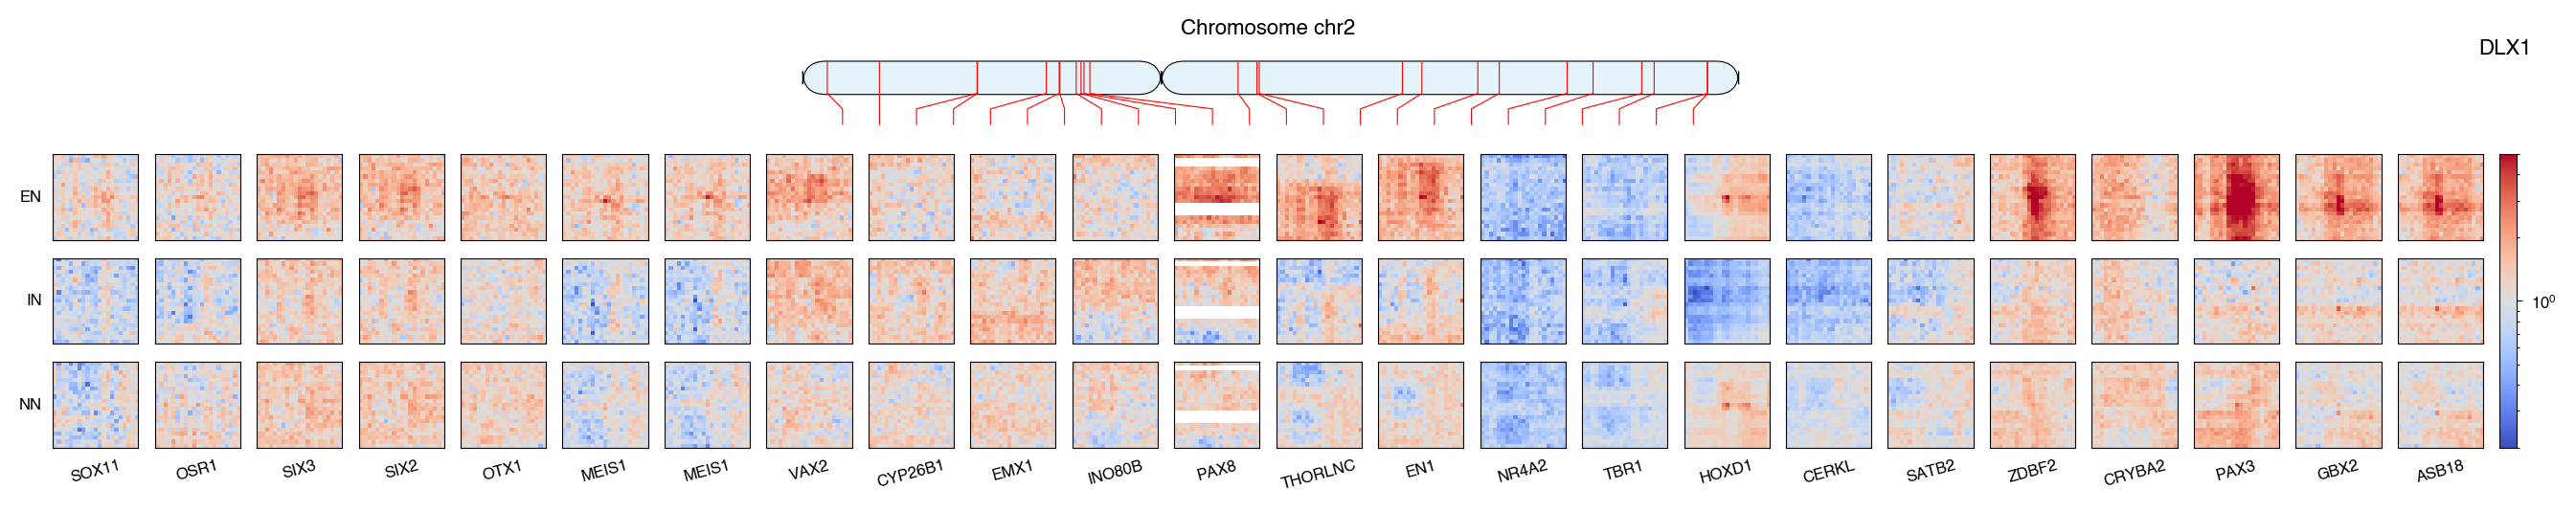

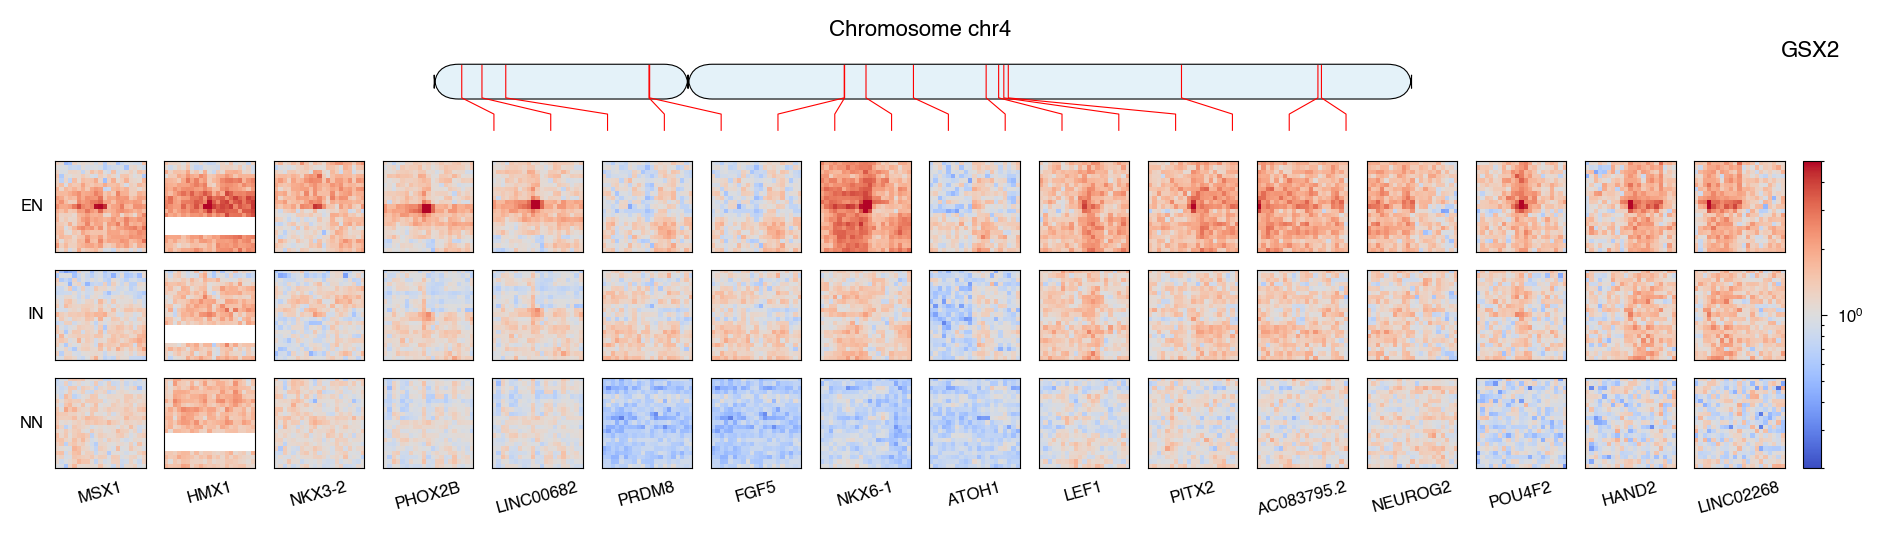

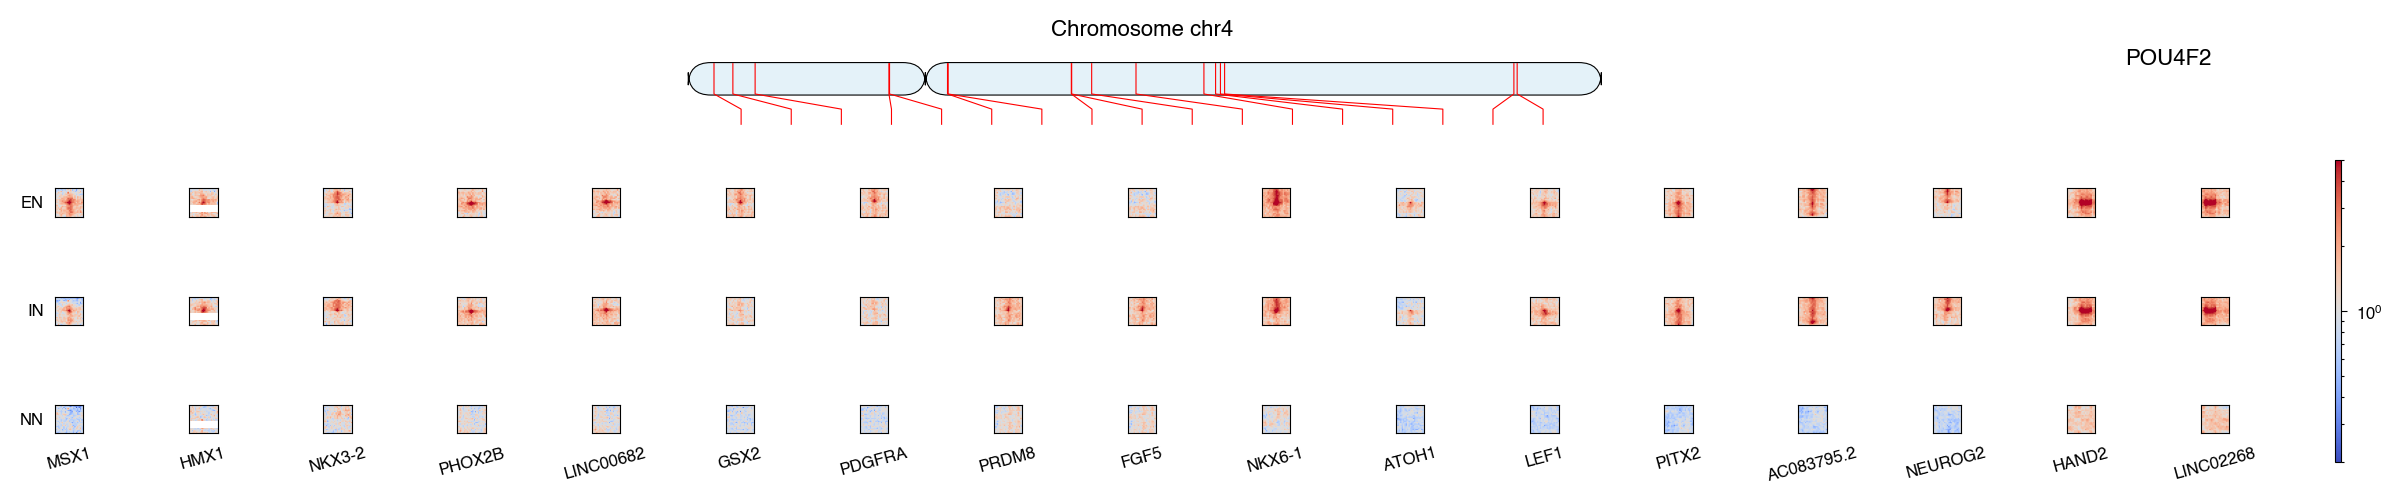

In [59]:
plot_genes = ['DLX1', 'GSX2', 'POU4F2']
for gene in plot_genes:
    utils.plot_gene_dots(
        gene, 
        hand_anch, 
        stat_gb, 
        # savefig=f"dot_snips.EN_IN.{gene}.pdf"
    )

plt.tight_layout()

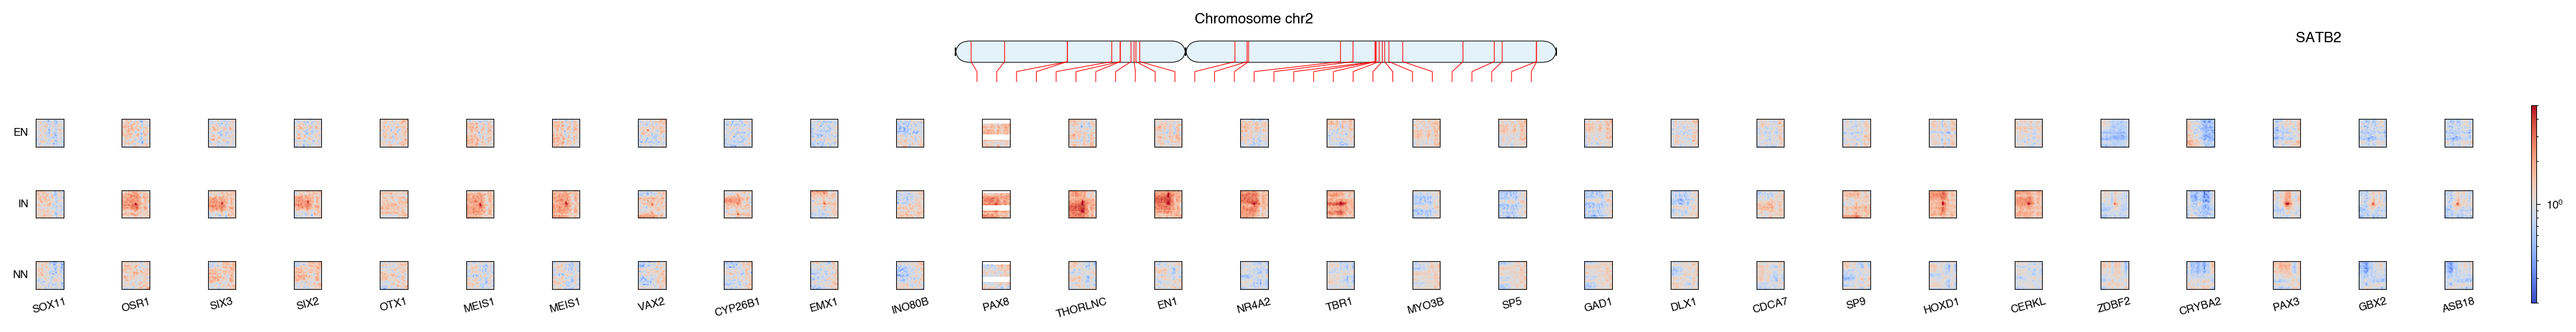

In [55]:
plot_genes = ["SATB2"]
for gene in plot_genes:
    utils.plot_gene_dots(
        gene, 
        hand_anch, 
        stat_gb, 
        # savefig=f"dot_snips.EN_IN.{gene}.pdf"
    )

plt.tight_layout()

# Plot: average dot for dot clusters

In [8]:
# Select required coolers
res = 20_000
pl_clrs = {
    "EN": clrs[res]["EN"],
    "IN": clrs[res]['IN'],
    "NN": clrs[res]['NN'],
}
pl_grps = list(pl_clrs.keys())

In [9]:
# Expected
pl_cvd = {}
nproc = 20
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

EN
IN
NN


In [10]:
# Load cluster annotation
dot_clust_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/polycomb_loop_clusters_update_June25.tsv"
dot_clust = pd.read_csv(dot_clust_path, index_col=0)
cls = dot_clust['cluster_name'].unique()
print(cls)
dot_clust.head()

['Neuron-specific' 'EN-prevalent' 'IN-prevalent' 'Common' 'IN-specific'
 'EN-specific' 'NN-specific']


chrom1    start1      end1 chrom2    start2      end2  \
0   chr1  18630000  18640000   chr1  24930000  24940000   
1   chr1  18630000  18640000   chr1  44410000  44420000   
2   chr1  18630000  18640000   chr1  46480000  46490000   
3   chr1  18630000  18640000   chr1  47180000  47250000   
4   chr1  18630000  18640000   chr1  47430000  47440000   

                                                loop     cluster_name  \
0  (('chr1', 18630000, 18640000), ('chr1', 249300...  Neuron-specific   
1  (('chr1', 18630000, 18640000), ('chr1', 444100...  Neuron-specific   
2  (('chr1', 18630000, 18640000), ('chr1', 464800...  Neuron-specific   
3  (('chr1', 18630000, 18640000), ('chr1', 471800...  Neuron-specific   
4  (('chr1', 18630000, 18640000), ('chr1', 474300...  Neuron-specific   

   cluster_id gene1            gene2  
0           2  PAX7            RUNX3  
1           2  PAX7           RNF220  
2           9  PAX7                -  
3           9  PAX7  TAL1,AL135960.1  
4           2  PAX7  FOXD2,FOXD2-AS1

In [12]:
# This value is mentioned in manuscript
spec_cl = ['IN-specific', 'EN-specific']
dot_clust.loc[dot_clust['cluster_name'].isin(spec_cl)].shape[0]

196

In [30]:
# Load cluster annotation
dot_clust_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/polycomb_loop_clusters_MajType_update_June25.tsv"
dot_clust = pd.read_csv(dot_clust_path, index_col=0)
cls = dot_clust['cluster_name'].unique()
print(cls)
dot_clust.head()

['Neurons' 'Pvalb' 'EN' 'Common' 'Sst' 'Lamp5' 'Sncg' 'IN' 'L4']


chrom1    start1      end1 chrom2    start2      end2  \
0   chr1  18630000  18640000   chr1  24930000  24940000   
1   chr1  18630000  18640000   chr1  44410000  44420000   
2   chr1  18630000  18640000   chr1  46480000  46490000   
3   chr1  18630000  18640000   chr1  47180000  47250000   
4   chr1  18630000  18640000   chr1  47430000  47440000   

                                                loop cluster_name  cluster_id  \
0  (('chr1', 18630000, 18640000), ('chr1', 249300...      Neurons           6   
1  (('chr1', 18630000, 18640000), ('chr1', 444100...      Neurons          12   
2  (('chr1', 18630000, 18640000), ('chr1', 464800...      Neurons           7   
3  (('chr1', 18630000, 18640000), ('chr1', 471800...      Neurons           7   
4  (('chr1', 18630000, 18640000), ('chr1', 474300...      Neurons          12   

  gene1            gene2  
0  PAX7            RUNX3  
1  PAX7           RNF220  
2  PAX7                -  
3  PAX7  TAL1,AL135960.1  
4  PAX7  FOXD2,FOXD2-AS1

In [31]:
dot_clust['ucsc'] = dot_clust['chrom1'] + ':' + dot_clust['start1'].astype(str) + '-' + dot_clust['end1'].astype(str) + ' & ' + \
    dot_clust['chrom2'] + ':' + dot_clust['start2'].astype(str) + '-' + dot_clust['end2'].astype(str)

In [56]:
stack = {grp: {} for grp in pl_grps}
flank = 15 * res
nproc = 30

cl_order = ['EN-specific', 'EN-prevalent', 'Neuron-specific', 'IN-prevalent', 
            'IN-specific', 'NN-specific', 'Common']

for grp in pl_grps:
    for cl in cl_order:
        print(grp, cl)
        stack[grp][cl] = coolpup.pileup(
            pl_clrs[grp], 
            dot_clust.loc[dot_clust['cluster_name'] == cl], 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            mindist=int(3e6),
            nproc=nproc
        )

EN EN-specific


INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr14', 'chr14'): 1
INFO:coolpuppy:('chr13', 'chr13'): 3
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 7
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr5', 'chr5'): 1
INFO:coolpuppy:('chr6', 'chr6'): 2
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr3', 'chr3'): 9
INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:('chr2', 'chr2'): 35
INFO:coolpuppy:Total number of piled up windows: 89


EN EN-prevalent


INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr18', 'chr18'): 3
INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 8
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr9', 'chr9'): 18
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr11', 'chr11'): 5
INFO:coolpuppy:('chr7', 'chr7'): 31
INFO:coolpuppy:('chr6', 'chr6'): 62
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr5', 'chr5'): 83
INFO:coolpuppy:('chr4', 'chr4'): 47
INFO:coolpuppy:('chr1', 'chr1'): 45
INFO:coolpuppy:('chr2', 'chr2'): 82
INFO:coolpuppy:Total number of piled up windows: 434


EN Neuron-specific


INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr15', 'chr15'): 8
INFO:coolpuppy:('chr14', 'chr14'): 9
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr9', 'chr9'): 13
INFO:coolpuppy:('chr11', 'chr11'): 15
INFO:coolpuppy:('chr10', 'chr10'): 20
INFO:coolpuppy:('chr12', 'chr12'): 4
INFO:coolpuppy:('chr8', 'chr8'): 17
INFO:coolpuppy:('chr7', 'chr7'): 29
INFO:coolpuppy:('chr6', 'chr6'): 48
INFO:coolpuppy:('chr5', 'chr5'): 78
INFO:coolpuppy:('chr4', 'chr4'): 40
INFO:coolpuppy:('chr3', 'chr3'): 23
INFO:coolpuppy:('chr1', 'chr1'): 99
INFO:coolpuppy:('chr2', 'chr2'): 28
INFO:coolpuppy:Total number of piled up windows: 453


EN IN-prevalent


INFO:coolpuppy:('chr18', 'chr18'): 7
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 5
INFO:coolpuppy:('chr15', 'chr15'): 7
INFO:coolpuppy:('chr14', 'chr14'): 2
INFO:coolpuppy:('chr11', 'chr11'): 8
INFO:coolpuppy:('chr10', 'chr10'): 25
INFO:coolpuppy:('chr8', 'chr8'): 7
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr6', 'chr6'): 28
INFO:coolpuppy:('chr5', 'chr5'): 28
INFO:coolpuppy:('chr4', 'chr4'): 23
INFO:coolpuppy:('chr3', 'chr3'): 8
INFO:coolpuppy:('chr1', 'chr1'): 22
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 245


EN IN-specific


INFO:coolpuppy:('chr17', 'chr17'): 1
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr10', 'chr10'): 8
INFO:coolpuppy:('chr8', 'chr8'): 4
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 107


EN NN-specific


INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr13', 'chr13'): 4
INFO:coolpuppy:('chr9', 'chr9'): 1
INFO:coolpuppy:('chr12', 'chr12'): 1
INFO:coolpuppy:('chr11', 'chr11'): 1
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 20
INFO:coolpuppy:('chr4', 'chr4'): 2
INFO:coolpuppy:('chr2', 'chr2'): 29
INFO:coolpuppy:Total number of piled up windows: 66


EN Common


INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr6', 'chr6'): 33
INFO:coolpuppy:('chr5', 'chr5'): 19
INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 25
INFO:coolpuppy:Total number of piled up windows: 119


IN EN-specific


INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr14', 'chr14'): 1
INFO:coolpuppy:('chr13', 'chr13'): 3
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 7
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr6', 'chr6'): 2
INFO:coolpuppy:('chr5', 'chr5'): 1
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr3', 'chr3'): 9
INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:('chr2', 'chr2'): 35
INFO:coolpuppy:Total number of piled up windows: 89


IN EN-prevalent


INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr18', 'chr18'): 3
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 8
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr9', 'chr9'): 18
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr11', 'chr11'): 5
INFO:coolpuppy:('chr7', 'chr7'): 31
INFO:coolpuppy:('chr6', 'chr6'): 62
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr5', 'chr5'): 83
INFO:coolpuppy:('chr4', 'chr4'): 47
INFO:coolpuppy:('chr1', 'chr1'): 45
INFO:coolpuppy:('chr2', 'chr2'): 82
INFO:coolpuppy:Total number of piled up windows: 434


IN Neuron-specific


INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr14', 'chr14'): 9
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr15', 'chr15'): 8
INFO:coolpuppy:('chr9', 'chr9'): 13
INFO:coolpuppy:('chr11', 'chr11'): 15
INFO:coolpuppy:('chr10', 'chr10'): 20
INFO:coolpuppy:('chr8', 'chr8'): 17
INFO:coolpuppy:('chr12', 'chr12'): 4
INFO:coolpuppy:('chr7', 'chr7'): 29
INFO:coolpuppy:('chr6', 'chr6'): 48
INFO:coolpuppy:('chr5', 'chr5'): 78
INFO:coolpuppy:('chr4', 'chr4'): 40
INFO:coolpuppy:('chr3', 'chr3'): 23
INFO:coolpuppy:('chr1', 'chr1'): 99
INFO:coolpuppy:('chr2', 'chr2'): 28
INFO:coolpuppy:Total number of piled up windows: 453


IN IN-prevalent


INFO:coolpuppy:('chr18', 'chr18'): 7
INFO:coolpuppy:('chr17', 'chr17'): 5
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr15', 'chr15'): 7
INFO:coolpuppy:('chr14', 'chr14'): 2
INFO:coolpuppy:('chr11', 'chr11'): 8
INFO:coolpuppy:('chr10', 'chr10'): 25
INFO:coolpuppy:('chr8', 'chr8'): 7
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr6', 'chr6'): 28
INFO:coolpuppy:('chr5', 'chr5'): 28
INFO:coolpuppy:('chr4', 'chr4'): 23
INFO:coolpuppy:('chr3', 'chr3'): 8
INFO:coolpuppy:('chr1', 'chr1'): 22
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 245


IN IN-specific


INFO:coolpuppy:('chr17', 'chr17'): 1
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr10', 'chr10'): 8
INFO:coolpuppy:('chr8', 'chr8'): 4
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 107


IN NN-specific


INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr13', 'chr13'): 4
INFO:coolpuppy:('chr9', 'chr9'): 1
INFO:coolpuppy:('chr12', 'chr12'): 1
INFO:coolpuppy:('chr11', 'chr11'): 1
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 20
INFO:coolpuppy:('chr4', 'chr4'): 2
INFO:coolpuppy:('chr2', 'chr2'): 29
INFO:coolpuppy:Total number of piled up windows: 66


IN Common


INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr6', 'chr6'): 33
INFO:coolpuppy:('chr5', 'chr5'): 19
INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 25
INFO:coolpuppy:Total number of piled up windows: 119


NN EN-specific


INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr14', 'chr14'): 1
INFO:coolpuppy:('chr13', 'chr13'): 3
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 7
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr6', 'chr6'): 2
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr5', 'chr5'): 1
INFO:coolpuppy:('chr3', 'chr3'): 9
INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:('chr2', 'chr2'): 35
INFO:coolpuppy:Total number of piled up windows: 89


NN EN-prevalent


INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr18', 'chr18'): 3
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 8
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr9', 'chr9'): 18
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr11', 'chr11'): 5
INFO:coolpuppy:('chr7', 'chr7'): 31
INFO:coolpuppy:('chr6', 'chr6'): 62
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr5', 'chr5'): 83
INFO:coolpuppy:('chr4', 'chr4'): 47
INFO:coolpuppy:('chr1', 'chr1'): 45
INFO:coolpuppy:('chr2', 'chr2'): 82
INFO:coolpuppy:Total number of piled up windows: 434


NN Neuron-specific


INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr14', 'chr14'): 9
INFO:coolpuppy:('chr15', 'chr15'): 8
INFO:coolpuppy:('chr13', 'chr13'): 11
INFO:coolpuppy:('chr9', 'chr9'): 13
INFO:coolpuppy:('chr11', 'chr11'): 15
INFO:coolpuppy:('chr10', 'chr10'): 20
INFO:coolpuppy:('chr8', 'chr8'): 17
INFO:coolpuppy:('chr12', 'chr12'): 4
INFO:coolpuppy:('chr7', 'chr7'): 29
INFO:coolpuppy:('chr6', 'chr6'): 48
INFO:coolpuppy:('chr4', 'chr4'): 40
INFO:coolpuppy:('chr5', 'chr5'): 78
INFO:coolpuppy:('chr3', 'chr3'): 23
INFO:coolpuppy:('chr1', 'chr1'): 99
INFO:coolpuppy:('chr2', 'chr2'): 28
INFO:coolpuppy:Total number of piled up windows: 453


NN IN-prevalent


INFO:coolpuppy:('chr18', 'chr18'): 7
INFO:coolpuppy:('chr17', 'chr17'): 5
INFO:coolpuppy:('chr15', 'chr15'): 7
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr14', 'chr14'): 2
INFO:coolpuppy:('chr11', 'chr11'): 8
INFO:coolpuppy:('chr10', 'chr10'): 25
INFO:coolpuppy:('chr8', 'chr8'): 7
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr6', 'chr6'): 28
INFO:coolpuppy:('chr5', 'chr5'): 28
INFO:coolpuppy:('chr4', 'chr4'): 23
INFO:coolpuppy:('chr3', 'chr3'): 8
INFO:coolpuppy:('chr1', 'chr1'): 22
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 245


NN IN-specific


INFO:coolpuppy:('chr17', 'chr17'): 1
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr10', 'chr10'): 8
INFO:coolpuppy:('chr8', 'chr8'): 4
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 63
INFO:coolpuppy:Total number of piled up windows: 107


NN NN-specific


INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr13', 'chr13'): 4
INFO:coolpuppy:('chr9', 'chr9'): 1
INFO:coolpuppy:('chr12', 'chr12'): 1
INFO:coolpuppy:('chr11', 'chr11'): 1
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr7', 'chr7'): 1
INFO:coolpuppy:('chr6', 'chr6'): 20
INFO:coolpuppy:('chr4', 'chr4'): 2
INFO:coolpuppy:('chr2', 'chr2'): 29
INFO:coolpuppy:Total number of piled up windows: 66


NN Common


INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr17', 'chr17'): 2
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr7', 'chr7'): 11
INFO:coolpuppy:('chr6', 'chr6'): 33
INFO:coolpuppy:('chr5', 'chr5'): 19
INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:('chr2', 'chr2'): 25
INFO:coolpuppy:Total number of piled up windows: 119


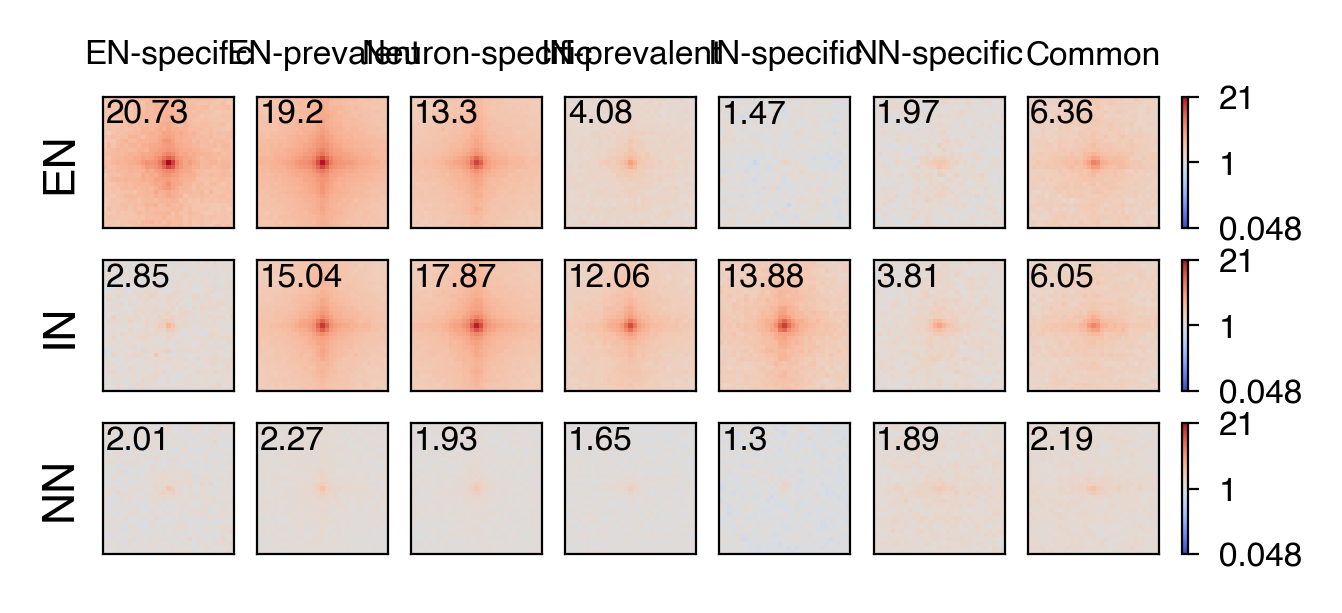

In [60]:
# summer_2025 annotation
utils.plot_av_dot_2d(stack, 21)
# plt.savefig('av_dot_clusts.pdf', bbox_inches='tight')

# Plot: boxplots with expressions by cluster

In [61]:
!cp /tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Summer2025_restart/5_Expression_vs_loops.ipynb .

In [62]:
subt_df_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Summer2025_restart/Loops_and_expressions.csv"
subt_df = pd.read_csv(subt_df_path)
subt_df

Cluster        gene  expression      loop Cell type
0         ASC  AC003986.3    0.000251  0.000123        NN
1     L2/3-IT  AC003986.3    0.032808  0.000292        EN
2       L4-IT  AC003986.3    0.003252  0.000715        EN
3       L5-IT  AC003986.3    0.053715  0.000550        EN
4       L6-IT  AC003986.3    0.001294  0.000291        EN
...       ...         ...         ...       ...       ...
4532      OPC  ZNF503-AS2    0.028943  0.000040        NN
4533    Pvalb  ZNF503-AS2    0.087808  0.000250        IN
4534     Sncg  ZNF503-AS2    0.001995  0.000270        IN
4535      Sst  ZNF503-AS2    0.004043  0.000455        IN
4536      Vip  ZNF503-AS2    0.002433  0.000332        IN

[4537 rows x 5 columns]

Text(0.5, 1.0, 'NR2E1')

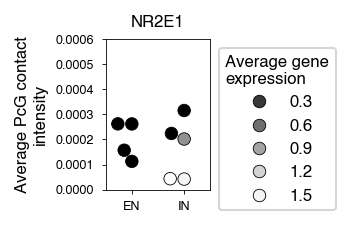

In [122]:
gene = 'NR2E1'
plot_df = subt_df.loc[(subt_df['gene'] == gene) & (subt_df['Cell type'] != 'NN')]

plt.figure(figsize=[0.9, 1.3], dpi=150)
sns.swarmplot(data=plot_df, x="Cell type", y="loop", hue='expression', 
              palette='Greys_r', linewidth=0.4, size=6)
plt.legend(loc="upper left", bbox_to_anchor=[1, 1], title='Average gene\nexpression')
plt.ylabel("Average PcG contact\nintensity")
plt.xlabel('')
plt.ylim([0, 0.0006])
plt.title(gene)

# Plot: average dot for dot clusters (subtypes)

In [33]:
# Select required coolers
res = 100_000
pl_clrs = {
    "L2-3-IT": clrs[res]['L2-3-IT'],
    "L4-IT": clrs[res]["L4-IT"],
    "L5-IT": clrs[res]['L5-IT'],
    # "L5-6-NP": clrs[res]['L5-6-NP'],
    "L6-IT": clrs[res]['L6-IT'],
    # "L6-IT-Car3": clrs[res]['L6-IT-Car3'],
    # "L6b": clrs[res]['L6b'],
    # "L6-CT": clrs[res]['L6-CT'],
    # "L5-ET": clrs[res]['L6b'],
    "Pvalb": clrs[res]['Pvalb'],
    "Sst": clrs[res]['Sst'],
    "Lamp5": clrs[res]['Lamp5'],
    # "Lamp5-Lhx6": clrs[res]['Lamp5-Lhx6'],
    "Vip": clrs[res]['Vip'],
    "Sncg": clrs[res]['Sncg'],  
}
pl_grps = list(pl_clrs.keys())

In [34]:
# Expected
pl_cvd = {}
nproc = 20
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

L2-3-IT
L4-IT
L5-IT
L6-IT
Pvalb
Sst
Lamp5
Vip
Sncg


In [35]:
# Load cluster annotation
dot_clust_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/polycomb_loop_clusters_MajType_update_June25.tsv"
dot_clust = pd.read_csv(dot_clust_path, index_col=0)
cls = dot_clust['cluster_name'].unique()
print(cls)
dot_clust.head()

['Neurons' 'Pvalb' 'EN' 'Common' 'Sst' 'Lamp5' 'Sncg' 'IN' 'L4']


chrom1    start1      end1 chrom2    start2      end2  \
0   chr1  18630000  18640000   chr1  24930000  24940000   
1   chr1  18630000  18640000   chr1  44410000  44420000   
2   chr1  18630000  18640000   chr1  46480000  46490000   
3   chr1  18630000  18640000   chr1  47180000  47250000   
4   chr1  18630000  18640000   chr1  47430000  47440000   

                                                loop cluster_name  cluster_id  \
0  (('chr1', 18630000, 18640000), ('chr1', 249300...      Neurons           6   
1  (('chr1', 18630000, 18640000), ('chr1', 444100...      Neurons          12   
2  (('chr1', 18630000, 18640000), ('chr1', 464800...      Neurons           7   
3  (('chr1', 18630000, 18640000), ('chr1', 471800...      Neurons           7   
4  (('chr1', 18630000, 18640000), ('chr1', 474300...      Neurons          12   

  gene1            gene2  
0  PAX7            RUNX3  
1  PAX7           RNF220  
2  PAX7                -  
3  PAX7  TAL1,AL135960.1  
4  PAX7  FOXD2,FOXD2-AS1

In [31]:
dot_clust['ucsc'] = dot_clust['chrom1'] + ':' + dot_clust['start1'].astype(str) + '-' + dot_clust['end1'].astype(str) + ' & ' + \
    dot_clust['chrom2'] + ':' + dot_clust['start2'].astype(str) + '-' + dot_clust['end2'].astype(str)

In [32]:
dot_clust.loc[dot_clust['cluster_name'] == 'Lamp5', 'ucsc'].head(40)

28       chr1:24930000-24940000 & chr1:92460000-92500000
59     chr1:46480000-46490000 & chr1:220880000-220890000
139    chr1:90830000-90840000 & chr1:165350000-165360000
141    chr1:90830000-90840000 & chr1:197910000-197920000
145    chr1:90830000-90840000 & chr1:229490000-229500000
191      chr2:5690000-5700000 & chr2:156315000-156345000
200      chr2:5690000-5700000 & chr2:199450000-199480000
232    chr2:19350000-19360000 & chr2:236260000-236270000
250    chr2:44930000-44940000 & chr2:181680000-181690000
260      chr2:45000000-45010000 & chr2:72910000-72920000
298      chr2:66430000-66440000 & chr2:72140000-72150000
300    chr2:66430000-66440000 & chr2:113270000-113280000
319    chr2:66575000-66585000 & chr2:113270000-113280000
333    chr2:66575000-66585000 & chr2:218990000-219000000
353    chr2:72140000-72150000 & chr2:156315000-156345000
354    chr2:72140000-72150000 & chr2:161410000-161430000
360    chr2:72140000-72150000 & chr2:176060000-176170000
361    chr2:72140000-72150000 &

In [41]:
stack = {grp: {} for grp in pl_grps}
flank = 15 * res
nproc = 30

for grp in pl_grps:
    # for cl in ['EN', 'EN-IN', 'EN/IN', 'IN-EN', 'IN',  'NN', 'Common']:
    # for cl in ['Pvalb', 'Sst', 'Lamp5', 'Sncg', 'L4']:
    for cl in ['EN', 'IN']:
        print(grp, cl)
        stack[grp][cl] = coolpup.pileup(
            pl_clrs[grp], 
            dot_clust.loc[dot_clust['cluster_name'] == cl], 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            mindist=int(3e6),
            nproc=nproc
        )

L2-3-IT EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


L2-3-IT IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


L4-IT EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


L4-IT IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:Total number of piled up windows: 120


L5-IT EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


L5-IT IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


L6-IT EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


L6-IT IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


Pvalb EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


Pvalb IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


Sst EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


Sst IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:Total number of piled up windows: 120


Lamp5 EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


Lamp5 IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


Vip EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:Total number of piled up windows: 184


Vip IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


Sncg EN


INFO:coolpuppy:('chr20', 'chr20'): 3
INFO:coolpuppy:('chr13', 'chr13'): 5
INFO:coolpuppy:('chr14', 'chr14'): 5
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr9', 'chr9'): 5
INFO:coolpuppy:('chr7', 'chr7'): 16
INFO:coolpuppy:('chr6', 'chr6'): 30
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr4', 'chr4'): 18
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 6
INFO:coolpuppy:('chr2', 'chr2'): 69
INFO:coolpuppy:Total number of piled up windows: 184


Sncg IN


INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:('chr16', 'chr16'): 1
INFO:coolpuppy:('chr11', 'chr11'): 12
INFO:coolpuppy:('chr10', 'chr10'): 14
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr6', 'chr6'): 19
INFO:coolpuppy:('chr5', 'chr5'): 2
INFO:coolpuppy:('chr4', 'chr4'): 20
INFO:coolpuppy:('chr3', 'chr3'): 1
INFO:coolpuppy:('chr1', 'chr1'): 1
INFO:coolpuppy:('chr2', 'chr2'): 41
INFO:coolpuppy:Total number of piled up windows: 120


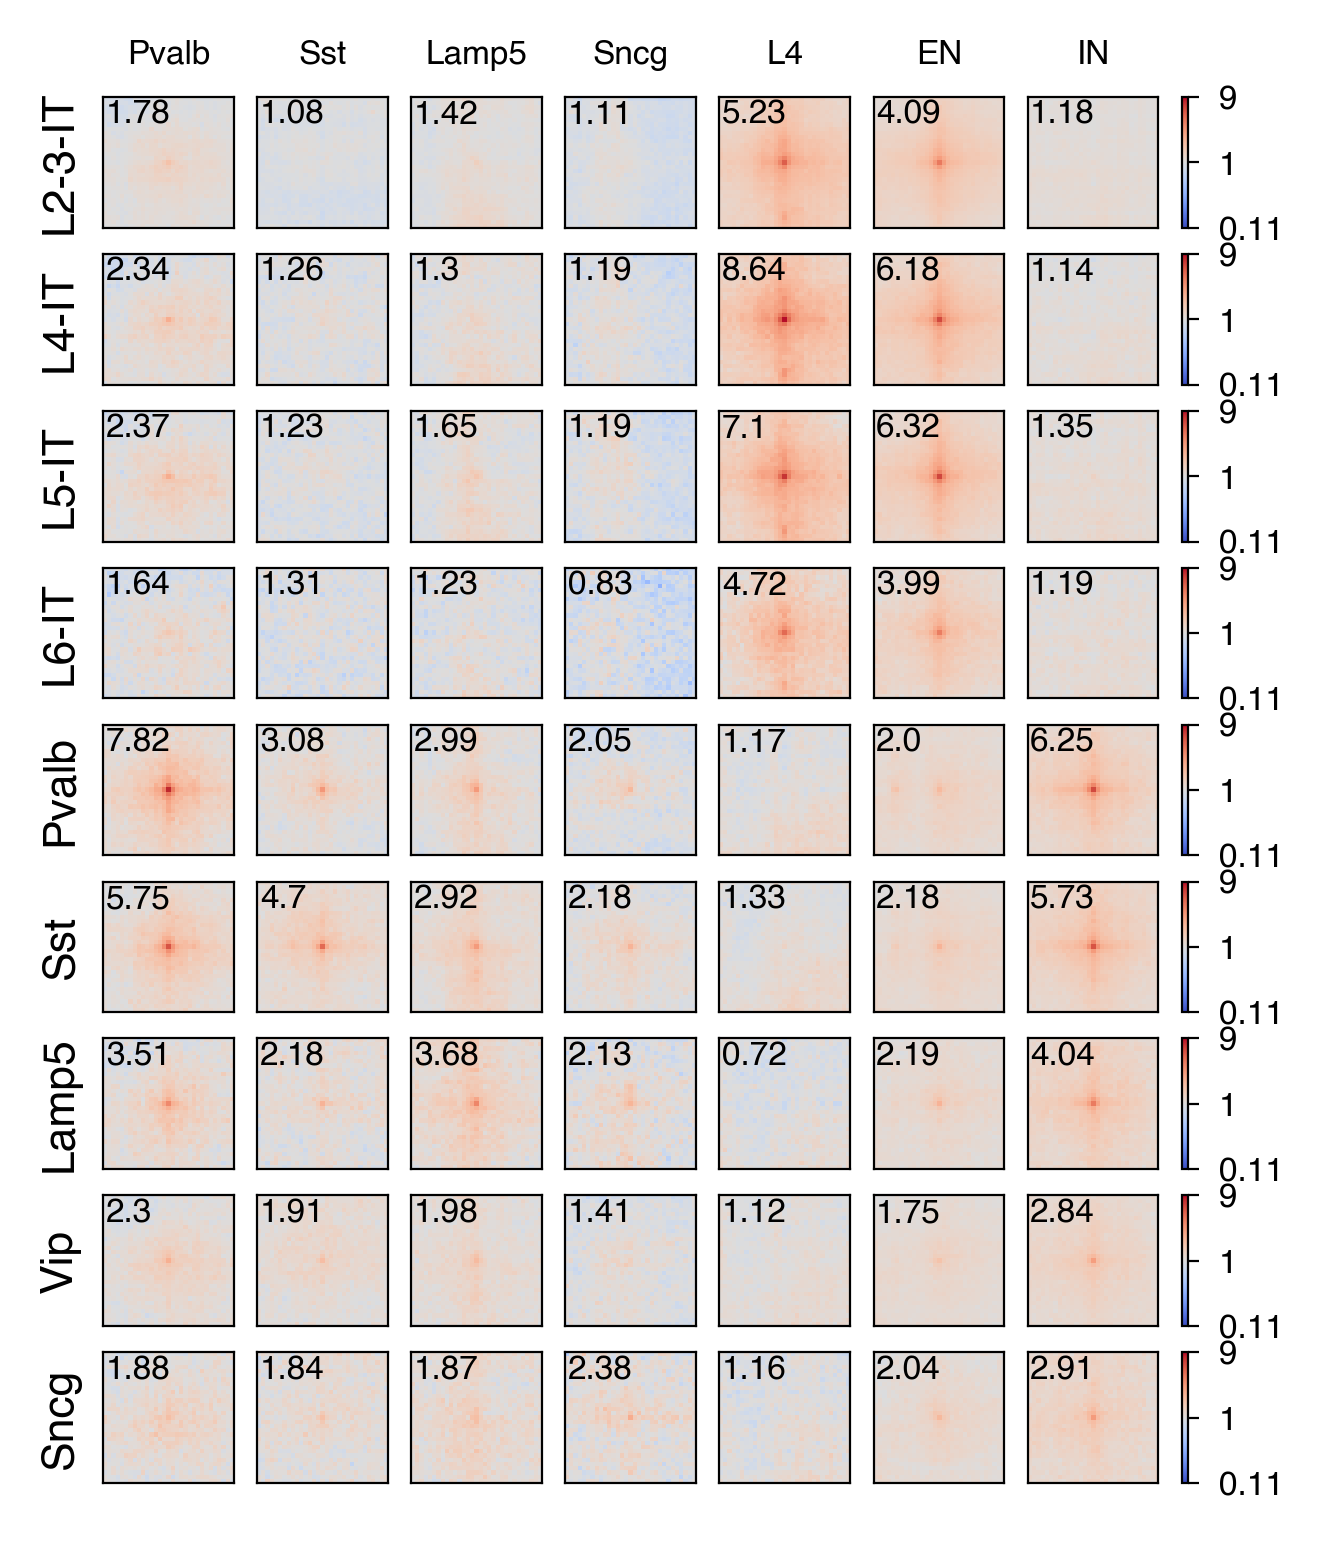

In [42]:
# summer_2025 annotation
utils.plot_av_dot_2d(stack, 9)

# Plot dots for subtypes from pseudobulk 

In [124]:
# Select required coolers
res = 100_000
pl_clrs = {
    "L2-3-IT": clrs[res]['L2-3-IT'],
    "L4-IT": clrs[res]["L4-IT"],
    "L5-IT": clrs[res]['L5-IT'],
    # "L5-6-NP": clrs[res]['L5-6-NP'],
    "L6-IT": clrs[res]['L6-IT'],
    # "L6-IT-Car3": clrs[res]['L6-IT-Car3'],
    # "L6b": clrs[res]['L6b'],
    # "L6-CT": clrs[res]['L6-CT'],
    # "L5-ET": clrs[res]['L6b'],
    "Pvalb": clrs[res]['Pvalb'],
    "Sst": clrs[res]['Sst'],
    "Lamp5": clrs[res]['Lamp5'],
    # "Lamp5-Lhx6": clrs[res]['Lamp5-Lhx6'],
    "Vip": clrs[res]['Vip'],
    "Sncg": clrs[res]['Sncg'],  
}
pl_grps = list(pl_clrs.keys())

In [125]:
# Expected
pl_cvd = {}
nproc = 20
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

L2-3-IT
L4-IT
L5-IT
L6-IT
Pvalb
Sst
Lamp5
Vip
Sncg


## Plot for top10 EN-prevalent and IN-prevalent

In [93]:
pca_load = utils.parse_pca_df(pca_loads_path, hand_anch)
pca_load.head(1)

PC1       PC2       PC3       PC4 chrom1    start1      end1 chrom2  \
0  0.031091  0.002427  0.006069 -0.011894   chr1  18630000  18640000   chr1   

     start2      end2 gene1  gene2           genes  
0  24930000  24940000  PAX7  RUNX3  PAX7 <-> RUNX3

In [14]:
pca_top = pd.concat([pca_load.nlargest(10, 'PC2'), 
                     pca_load.nsmallest(10, 'PC2')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

NameError: name 'pl_clrs' is not defined

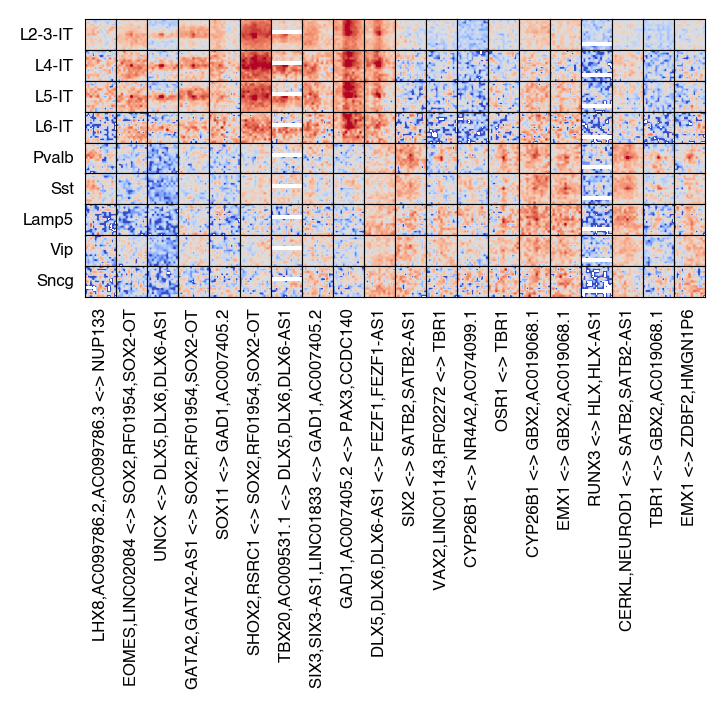

In [279]:
utils.plot_loads(pca_top, pl_grps, snips, vmax=8)
# plt.savefig("top_bottom_pca_dots.summer25.pdf", bbox_inches='tight')

In [280]:
pca_top = pd.concat([pca_load.nlargest(10, 'PC3'), 
                     pca_load.nsmallest(10, 'PC3')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

L2-3-IT
L4-IT
L5-IT
L6-IT
Pvalb
Sst
Lamp5
Vip
Sncg


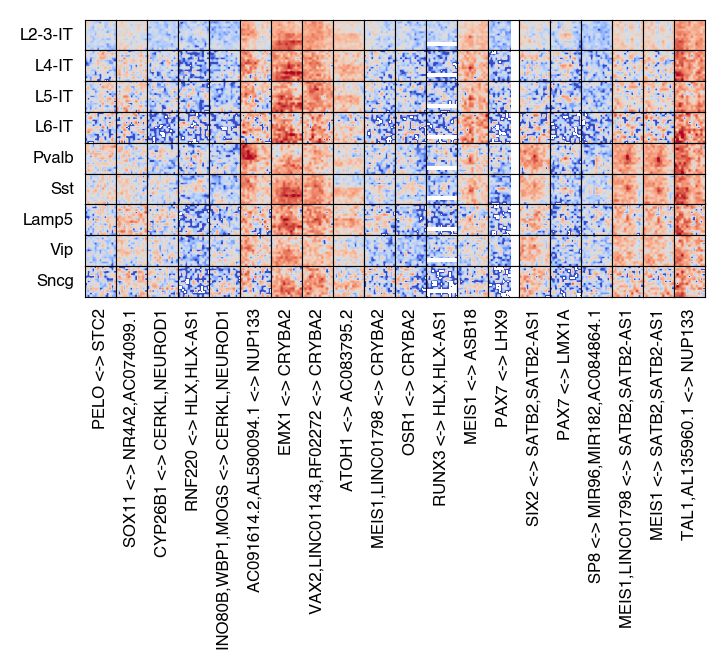

In [281]:
utils.plot_loads(pca_top, pl_grps, snips, vmax=8)
# plt.savefig("top_bottom_pca_dots.summer25.pdf", bbox_inches='tight')

# Silent vs active genes

In [86]:
hand_expr_subt_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/polycombed_genes_activity_in_cerebral_cortex.csv"
hand_expr_grp = pd.read_table(hand_expr_subt_path, sep=',', names=['gene', 'activity'], index_col=0)['activity']
hand_expr_grp.head()

gene
AC003986.3      Non-active
AC004080.2      Non-active
AC004080.4      Non-active
AC004080.5      Non-active
AC005224.2    Part. active
Name: activity, dtype: object

In [87]:
# Get anchors with non-expressed genes (both p-c and non-c)
def noex_genes(gene_l, noex_l):
    ex_l = [gene for gene in gene_l if gene not in noex_l]
    if len(ex_l) == 0:
        return True
    else:
        return False

# Keep genes that are present in rizzardi
hand_anch_flt = hand_anch.copy().fillna('no_gene')
hand_anch_flt['genes_nik'] = hand_anch_flt['genes'].str.split(',')\
    .apply(lambda genes: [gene for gene in genes if gene in hand_expr_grp.index])
hand_anch_flt = hand_anch_flt.loc[hand_anch_flt['genes_nik'].apply(len) > 0]

# Mark non-expressed genes based on Herring and Rizzardi
noex_l = hand_expr_grp.loc[hand_expr_grp == 'Non-active']
hand_anch_flt['noex'] = hand_anch_flt['genes_nik'].apply(noex_genes, args=[noex_l])
hand_anch_flt

chrom     start       end                 genes                genes_nik  \
0     chr1  18630000  18640000                  PAX7                   [PAX7]   
1     chr1  24930000  24940000                 RUNX3                  [RUNX3]   
2     chr1  44410000  44420000                RNF220                 [RNF220]   
4     chr1  47180000  47250000       TAL1,AL135960.1       [TAL1, AL135960.1]   
5     chr1  47430000  47440000       FOXD2,FOXD2-AS1       [FOXD2, FOXD2-AS1]   
..     ...       ...       ...                   ...                      ...   
254  chr20  21085000  21115000  LINC00237,AL121759.2  [LINC00237, AL121759.2]   
255  chr20  21380000  21410000     NKX2-4,AL158013.1     [NKX2-4, AL158013.1]   
256  chr20  21500000  21525000     NKX2-2,NKX2-2-AS1     [NKX2-2, NKX2-2-AS1]   
257  chr20  22560000  22590000       FOXA2,LINC00261       [FOXA2, LINC00261]   
258  chr20  38710000  38730000               SLC32A1                [SLC32A1]   

      noex  
0     True  
1     True  
2    False  
4    False  
5     True  
..     ...  
254  False  
255   True  
256  False  
257   True  
258  False  

[203 rows x 6 columns]

In [88]:
hand_noex_map = hand_anch_flt.drop_duplicates('genes').set_index('genes')['noex']

In [89]:
hand_expr_grp.loc[['OSR1', 'SIX3', 'MEIS1', 'VAX2', 'CYP26B1', 
                   'EMX1', 'THORLNC', 'EN1', 'NR4A2', 'TBR1', 
                   'HOXD1', 'ZDBF2', 'PAX3', 'GBX2']]

gene
OSR1         Non-active
SIX3         Non-active
MEIS1      Part. active
VAX2         Non-active
CYP26B1    Part. active
EMX1       Part. active
THORLNC      Non-active
EN1          Non-active
NR4A2      Part. active
TBR1       Part. active
HOXD1      Part. active
ZDBF2      Part. active
PAX3         Non-active
GBX2         Non-active
Name: activity, dtype: object

In [90]:
hand_expr_grp.loc[['SOX11', 'OSR1', 'SIX3', 'SIX2', 'OTX1', 'MEIS1', 
                   'VAX2', 'CYP26B1', 'EMX1', 'INO80B', 'PAX8', 'THORLNC', 'EN1',
                   'NR4A2', 'TBR1', 'HOXD1', 'CERKL', 'SATB2', 'ZDBF2', 'CRYBA2', 
                   'PAX3', 'GBX2', 'ASB18']]

gene
SOX11      Part. active
OSR1         Non-active
SIX3         Non-active
SIX2         Non-active
OTX1       Part. active
MEIS1      Part. active
VAX2         Non-active
CYP26B1    Part. active
EMX1       Part. active
INO80B     Part. active
PAX8       Part. active
THORLNC      Non-active
EN1          Non-active
NR4A2      Part. active
TBR1       Part. active
HOXD1      Part. active
CERKL      Part. active
SATB2      Part. active
ZDBF2      Part. active
CRYBA2       Non-active
PAX3         Non-active
GBX2         Non-active
ASB18      Part. active
Name: activity, dtype: object

In [91]:
hand_expr_grp.loc[['GSX2', 'POU4F2']]

gene
GSX2      Non-active
POU4F2    Non-active
Name: activity, dtype: object

## PC2

-0.022869370571472765 0.027218095391782108


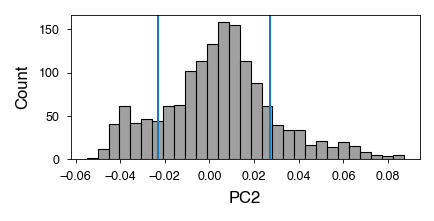

In [94]:
plt.figure(dpi=150, figsize=[3, 1.25])
sns.histplot(pca_load['PC2'], color='grey')
plt.axvline(pca_load['PC2'].quantile(0.15), linewidth=1)
plt.axvline(pca_load['PC2'].quantile(0.85), linewidth=1)
# plt.savefig("pc2_loadings_hist.pdf", bbox_inches='tight')
print(
    pca_load['PC2'].quantile(0.15),
    pca_load['PC2'].quantile(0.85),
)

<Axes: xlabel='gene1'>

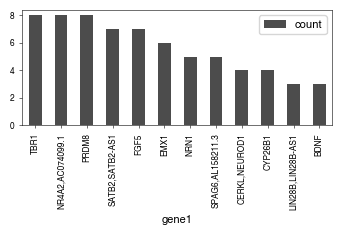

In [95]:
en_thr = pca_load['PC2'].quantile(0.15)
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC2'] < en_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("dot_count_pc2_EN.pdf", bbox_inches='tight')

In [31]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

TBR1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


TBR1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


NR4A2,AC074099.1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 L2-3-IT


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 L4-IT


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 L5-IT


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 L6-IT


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 Pvalb


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 Sst


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 Lamp5


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 Vip


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


PRDM8 Sncg


INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:Total number of piled up windows: 8


SATB2,SATB2-AS1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 L2-3-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 L4-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 L5-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 L6-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 Pvalb


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 Sst


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 Lamp5


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 Vip


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 Sncg


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


EMX1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 L2-3-IT


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 L4-IT


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 L5-IT


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 L6-IT


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 Pvalb


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 Sst


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 Lamp5


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 Vip


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NRN1 Sncg


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 L2-3-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 L4-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 L5-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 L6-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 Pvalb


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 Sst


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 Lamp5


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 Vip


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SPAG6,AL158211.3 Sncg


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


CERKL,NEUROD1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LIN28B,LIN28B-AS1 L2-3-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 L4-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 L5-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 L6-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 Pvalb


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 Sst


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 Lamp5


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 Vip


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


LIN28B,LIN28B-AS1 Sncg


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF L2-3-IT


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF L4-IT


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF L5-IT


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF L6-IT


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF Pvalb


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF Sst


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF Lamp5


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF Vip


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


BDNF Sncg


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:Total number of piled up windows: 3


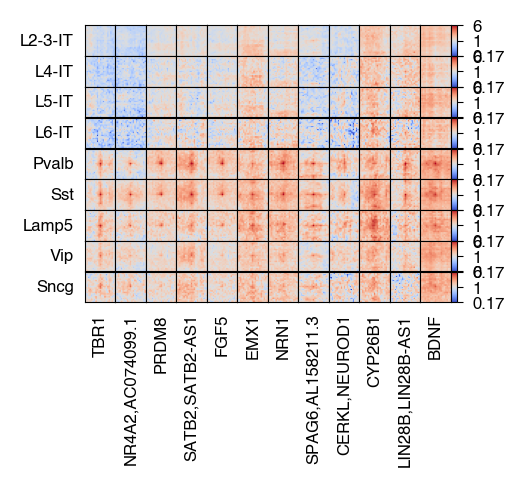

In [33]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("av_dot_pc2_IN.pdf", bbox_inches='tight')

<Axes: xlabel='gene1'>

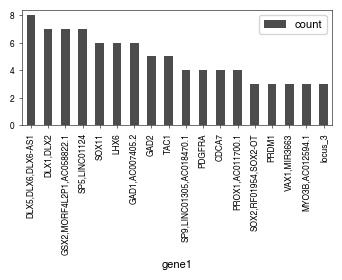

In [96]:
in_thr = pca_load['PC2'].quantile(0.85)
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC2'] > in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("dot_count_pc2_IN.pdf", bbox_inches='tight')

In [100]:
pca_load.loc[pca_load['gene1'] == 'locus_3']

PC1       PC2       PC3       PC4 chrom1     start1       end1  \
1065  0.006234  0.039984  0.012338  0.001748   chr6  105975000  106000000   
1066 -0.004895  0.001663  0.033143 -0.017460   chr6  105975000  106000000   
1067 -0.001688  0.001385  0.036995 -0.001653   chr6  105975000  106000000   
1068 -0.000252  0.013802  0.022327 -0.000197   chr6  105975000  106000000   
1069 -0.003505  0.023033 -0.024812 -0.001601   chr6  105975000  106000000   

     chrom2     start2       end2    gene1                  gene2  \
1065   chr6  117250000  117280000  locus_3                  VGLL2   
1066   chr6  125730000  125740000  locus_3       HEY2, AL365259.1   
1067   chr6  133830000  133900000  locus_3  TARID,LINC01312,TCF21   
1068   chr6  137460000  137510000  locus_3                  OLIG3   
1069   chr6  149910000  149990000  locus_3       ULBP1,AL355497.1   

                                  genes  
1065                  locus_3 <-> VGLL2  
1066       locus_3 <-> HEY2, AL365259.1  
1067  locus_3 <-> TARID,LINC01312,TCF21  
1068                  locus_3 <-> OLIG3  
1069       locus_3 <-> ULBP1,AL355497.1

In [20]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

DLX5,DLX6,DLX6-AS1 L2-3-IT


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 L4-IT


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 L5-IT


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 L6-IT


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 Pvalb


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 Sst


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 Lamp5


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 Vip


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX5,DLX6,DLX6-AS1 Sncg


INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:Total number of piled up windows: 8


DLX1,DLX2 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 Sst


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 Vip


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


DLX1,DLX2 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 L2-3-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 L4-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 L5-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 L6-IT


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 Pvalb


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 Sst


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 Lamp5


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 Vip


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


GSX2,MORF4L2P1,AC058822.1 Sncg


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 Sst


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 Vip


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SP5,LINC01124 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SOX11 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 Sst


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 Vip


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 L2-3-IT


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 L4-IT


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 L5-IT


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 L6-IT


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 Pvalb


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 Sst


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 Lamp5


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 Vip


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


LHX6 Sncg


INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 Sst


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 Vip


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD2 L2-3-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 L4-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 L5-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 L6-IT


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 Pvalb


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 Sst


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 Lamp5


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 Vip


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD2 Sncg


INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 L2-3-IT


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 L4-IT


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 L5-IT


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 L6-IT


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 Pvalb


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 Sst


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 Lamp5


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 Vip


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 Sncg


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


SP9,LINC01305,AC018470.1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA L2-3-IT


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA L4-IT


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA L5-IT


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA L6-IT


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA Pvalb


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA Sst


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA Lamp5


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA Vip


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PDGFRA Sncg


INFO:coolpuppy:('chr4', 'chr4'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 Sst


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 Vip


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CDCA7 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 L2-3-IT


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 L4-IT


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 L5-IT


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 L6-IT


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 Pvalb


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 Sst


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 Lamp5


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 Vip


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


PROX1,AC011700.1 Sncg


INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SOX2,RF01954,SOX2-OT L2-3-IT


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT L4-IT


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT L5-IT


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT L6-IT


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT Pvalb


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT Sst


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT Lamp5


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT Vip


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT Sncg


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 L2-3-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 L4-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 L5-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 L6-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 Pvalb


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 Sst


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 Lamp5


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 Vip


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 Sncg


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 L2-3-IT


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 L4-IT


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 L5-IT


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 L6-IT


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 Pvalb


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 Sst


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 Lamp5


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 Vip


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


VAX1,MIR3663 Sncg


INFO:coolpuppy:('chr10', 'chr10'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 L2-3-IT


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 L4-IT


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 L5-IT


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 L6-IT


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 Pvalb


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 Sst


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 Lamp5


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 Vip


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


MYO3B,AC012594.1 Sncg


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 L2-3-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 L4-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 L5-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 L6-IT


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 Pvalb


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 Sst


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 Lamp5


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 Vip


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


locus_3 Sncg


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


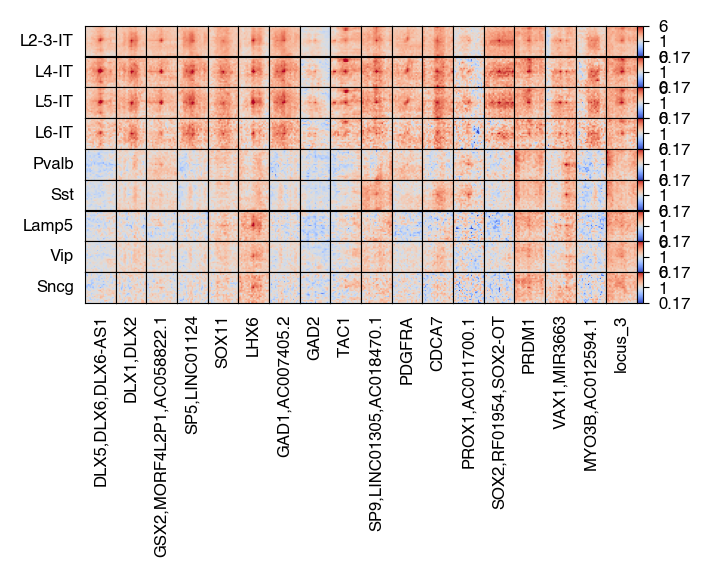

In [22]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("av_dot_pc2_EN.pdf", bbox_inches='tight')

<Axes: xlabel='gene1'>

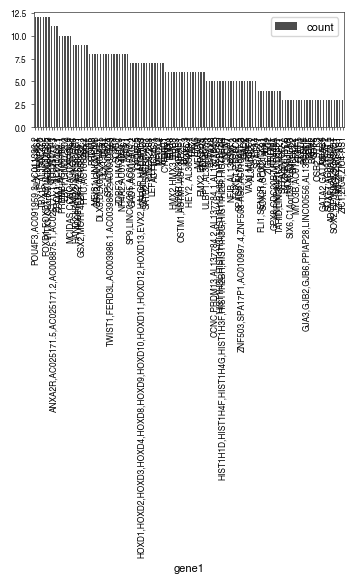

In [135]:
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[pca_load_pc2['noex2'] & 
                               (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("dot_count_pc2_EN.pdf", bbox_inches='tight')

In [136]:
flank = 10 * res
nproc = 20

genes = ["MEIS2,AC078909.1,AC078909.2", "TAC1", "FEZF2", "EYA4"]
# genes = ["SHOX2,RSRC1", "CCNC,PRDM13,AL137784.2,AL137784.1,AL137784.3", 
         # "OSTM1,ASTM1-AS1,NR2E1", "NUP133", 'OTP,WDR41']
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

MEIS2,AC078909.1,AC078909.2 L2-3-IT
MEIS2,AC078909.1,AC078909.2 L4-IT
MEIS2,AC078909.1,AC078909.2 L5-IT
MEIS2,AC078909.1,AC078909.2 L6-IT
MEIS2,AC078909.1,AC078909.2 Pvalb
MEIS2,AC078909.1,AC078909.2 Sst
MEIS2,AC078909.1,AC078909.2 Lamp5
MEIS2,AC078909.1,AC078909.2 Vip
MEIS2,AC078909.1,AC078909.2 Sncg
TAC1 L2-3-IT
TAC1 L4-IT
TAC1 L5-IT
TAC1 L6-IT
TAC1 Pvalb
TAC1 Sst
TAC1 Lamp5
TAC1 Vip
TAC1 Sncg
FEZF2 L2-3-IT
FEZF2 L4-IT
FEZF2 L5-IT
FEZF2 L6-IT
FEZF2 Pvalb
FEZF2 Sst
FEZF2 Lamp5
FEZF2 Vip
FEZF2 Sncg
EYA4 L2-3-IT
EYA4 L4-IT
EYA4 L5-IT
EYA4 L6-IT
EYA4 Pvalb
EYA4 Sst
EYA4 Lamp5
EYA4 Vip
EYA4 Sncg


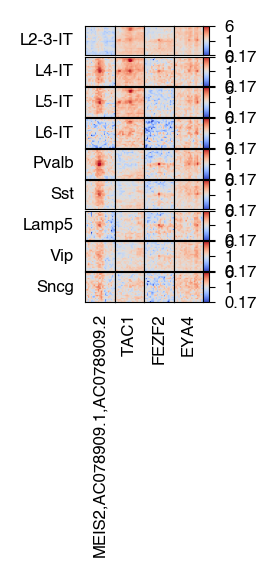

In [139]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("av_dot.fezf2_like_dots.pdf", bbox_inches='tight')

<Axes: xlabel='gene1'>

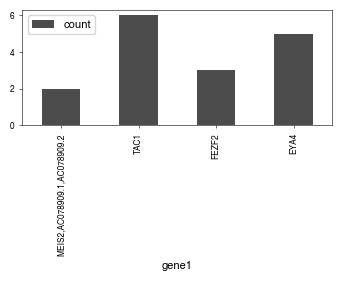

In [141]:
pca_load_cnts.loc[genes].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)
plt.savefig("dot_count_pc2_EN.pdf", bbox_inches='tight')

## PC3

<Axes: xlabel='PC3', ylabel='Count'>

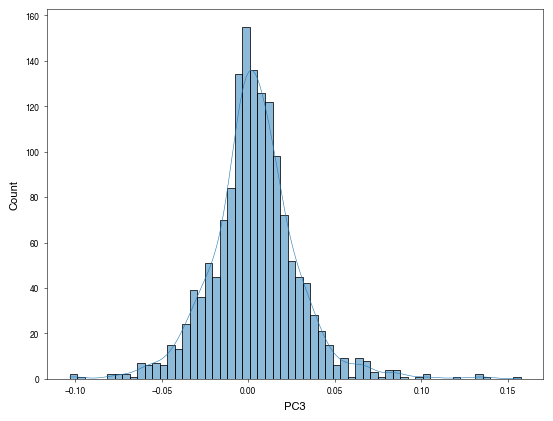

In [241]:
sns.histplot(pca_load['PC3'], kde=True)

In [251]:
in_thr = 0.03
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC3'] > in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2]

count
gene1                                                 
LHX6                                                 6
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3      5
SOX11                                                4
TBR1                                                 3

In [252]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

LHX6 L2-3-IT
LHX6 L4-IT
LHX6 L5-IT
LHX6 L6-IT
LHX6 Pvalb
LHX6 Sst
LHX6 Lamp5
LHX6 Vip
LHX6 Sncg
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 L2-3-IT
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 L4-IT
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 L5-IT
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 L6-IT
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 Pvalb
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 Sst
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 Lamp5
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 Vip
ZNF503,SPA17P1,AC010997.4,ZNF503-AS2,AC010997.3 Sncg
SOX11 L2-3-IT
SOX11 L4-IT
SOX11 L5-IT
SOX11 L6-IT
SOX11 Pvalb
SOX11 Sst
SOX11 Lamp5
SOX11 Vip
SOX11 Sncg
TBR1 L2-3-IT
TBR1 L4-IT
TBR1 L5-IT
TBR1 L6-IT
TBR1 Pvalb
TBR1 Sst
TBR1 Lamp5
TBR1 Vip
TBR1 Sncg


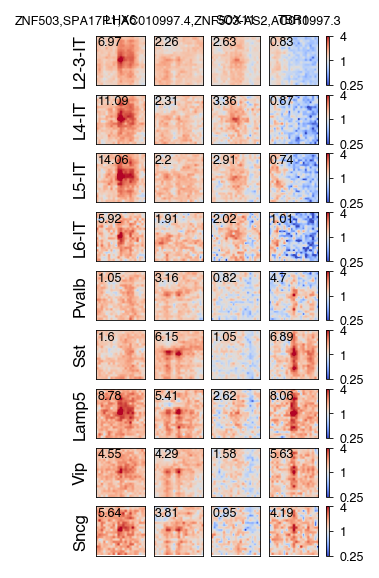

In [253]:
utils.plot_av_dot_2d(stack, 4, dpi=150)

In [255]:
in_thr = 0.03
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC3'] < -in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2]

count
gene1                       
PROX1,AC011700.1           7
NFIB,AL136366.1            5
HLX,HLX-AS1                5
SP8                        4
AC091614.2,AL590094.1      3
ZFHX4,ZFHX4-AS1            3

In [256]:
flank = 10 * res
nproc = 10

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

PROX1,AC011700.1 L2-3-IT
PROX1,AC011700.1 L4-IT
PROX1,AC011700.1 L5-IT
PROX1,AC011700.1 L6-IT
PROX1,AC011700.1 Pvalb
PROX1,AC011700.1 Sst
PROX1,AC011700.1 Lamp5
PROX1,AC011700.1 Vip
PROX1,AC011700.1 Sncg
NFIB,AL136366.1 L2-3-IT
NFIB,AL136366.1 L4-IT
NFIB,AL136366.1 L5-IT
NFIB,AL136366.1 L6-IT
NFIB,AL136366.1 Pvalb
NFIB,AL136366.1 Sst
NFIB,AL136366.1 Lamp5
NFIB,AL136366.1 Vip
NFIB,AL136366.1 Sncg
HLX,HLX-AS1 L2-3-IT
HLX,HLX-AS1 L4-IT
HLX,HLX-AS1 L5-IT
HLX,HLX-AS1 L6-IT
HLX,HLX-AS1 Pvalb
HLX,HLX-AS1 Sst
HLX,HLX-AS1 Lamp5
HLX,HLX-AS1 Vip
HLX,HLX-AS1 Sncg
SP8 L2-3-IT
SP8 L4-IT
SP8 L5-IT
SP8 L6-IT
SP8 Pvalb
SP8 Sst
SP8 Lamp5
SP8 Vip
SP8 Sncg
AC091614.2,AL590094.1 L2-3-IT
AC091614.2,AL590094.1 L4-IT
AC091614.2,AL590094.1 L5-IT
AC091614.2,AL590094.1 L6-IT
AC091614.2,AL590094.1 Pvalb
AC091614.2,AL590094.1 Sst
AC091614.2,AL590094.1 Lamp5
AC091614.2,AL590094.1 Vip
AC091614.2,AL590094.1 Sncg
ZFHX4,ZFHX4-AS1 L2-3-IT
ZFHX4,ZFHX4-AS1 L4-IT
ZFHX4,ZFHX4-AS1 L5-IT
ZFHX4,ZFHX4-AS1 L6-IT
ZFHX4,ZFHX4-AS1 

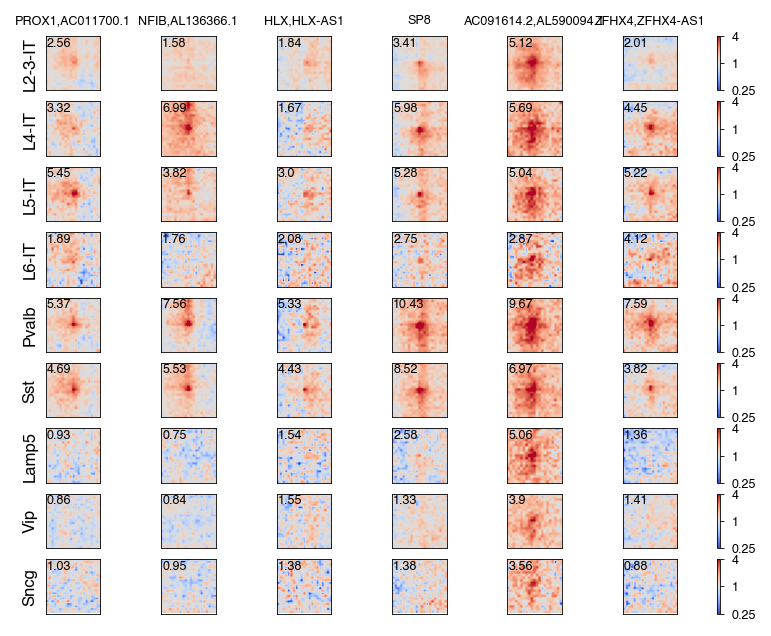

In [263]:
utils.plot_av_dot_2d(stack, 4, dpi=150, figsize=[6, 5])

## PC4

<Axes: xlabel='PC4', ylabel='Count'>

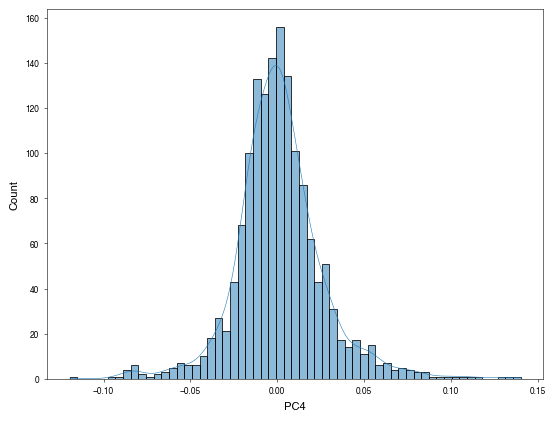

In [264]:
sns.histplot(pca_load['PC4'], kde=True)

In [265]:
in_thr = 0.03
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC4'] > in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2]

count
gene1                          
PROX1,AC011700.1              6
SP9,LINC01305,AC018470.1      5
HHEX                          3
NR4A2,AC074099.1              3
MEIS1                         3
SP8                           3

In [266]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

PROX1,AC011700.1 L2-3-IT
PROX1,AC011700.1 L4-IT
PROX1,AC011700.1 L5-IT
PROX1,AC011700.1 L6-IT
PROX1,AC011700.1 Pvalb
PROX1,AC011700.1 Sst
PROX1,AC011700.1 Lamp5
PROX1,AC011700.1 Vip
PROX1,AC011700.1 Sncg
SP9,LINC01305,AC018470.1 L2-3-IT
SP9,LINC01305,AC018470.1 L4-IT
SP9,LINC01305,AC018470.1 L5-IT
SP9,LINC01305,AC018470.1 L6-IT
SP9,LINC01305,AC018470.1 Pvalb
SP9,LINC01305,AC018470.1 Sst
SP9,LINC01305,AC018470.1 Lamp5
SP9,LINC01305,AC018470.1 Vip
SP9,LINC01305,AC018470.1 Sncg
HHEX L2-3-IT
HHEX L4-IT
HHEX L5-IT
HHEX L6-IT
HHEX Pvalb
HHEX Sst
HHEX Lamp5
HHEX Vip
HHEX Sncg
NR4A2,AC074099.1 L2-3-IT
NR4A2,AC074099.1 L4-IT
NR4A2,AC074099.1 L5-IT
NR4A2,AC074099.1 L6-IT
NR4A2,AC074099.1 Pvalb
NR4A2,AC074099.1 Sst
NR4A2,AC074099.1 Lamp5
NR4A2,AC074099.1 Vip
NR4A2,AC074099.1 Sncg
MEIS1 L2-3-IT
MEIS1 L4-IT
MEIS1 L5-IT
MEIS1 L6-IT
MEIS1 Pvalb
MEIS1 Sst
MEIS1 Lamp5
MEIS1 Vip
MEIS1 Sncg
SP8 L2-3-IT
SP8 L4-IT
SP8 L5-IT
SP8 L6-IT
SP8 Pvalb
SP8 Sst
SP8 Lamp5
SP8 Vip
SP8 Sncg


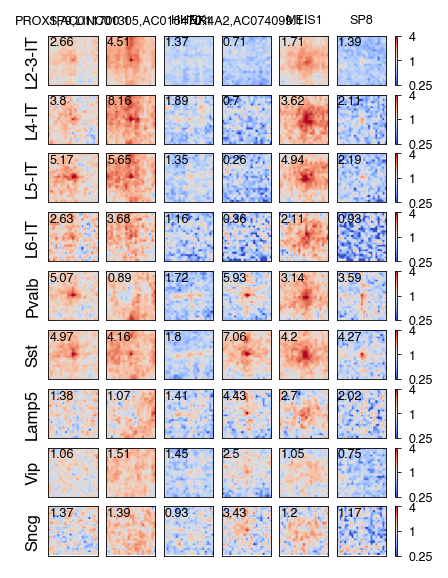

In [267]:
utils.plot_av_dot_2d(stack, 4, dpi=150)

In [268]:
in_thr = 0.03
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC4'] < -in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2]

count
gene1                       
AC091614.2,AL590094.1      4
HLX,HLX-AS1                4
TBX15,AL139420.2           3

In [269]:
flank = 10 * res
nproc = 10

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

AC091614.2,AL590094.1 L2-3-IT
AC091614.2,AL590094.1 L4-IT
AC091614.2,AL590094.1 L5-IT
AC091614.2,AL590094.1 L6-IT
AC091614.2,AL590094.1 Pvalb
AC091614.2,AL590094.1 Sst
AC091614.2,AL590094.1 Lamp5
AC091614.2,AL590094.1 Vip
AC091614.2,AL590094.1 Sncg
HLX,HLX-AS1 L2-3-IT
HLX,HLX-AS1 L4-IT
HLX,HLX-AS1 L5-IT
HLX,HLX-AS1 L6-IT
HLX,HLX-AS1 Pvalb
HLX,HLX-AS1 Sst
HLX,HLX-AS1 Lamp5
HLX,HLX-AS1 Vip
HLX,HLX-AS1 Sncg
TBX15,AL139420.2 L2-3-IT
TBX15,AL139420.2 L4-IT
TBX15,AL139420.2 L5-IT
TBX15,AL139420.2 L6-IT
TBX15,AL139420.2 Pvalb
TBX15,AL139420.2 Sst
TBX15,AL139420.2 Lamp5
TBX15,AL139420.2 Vip
TBX15,AL139420.2 Sncg


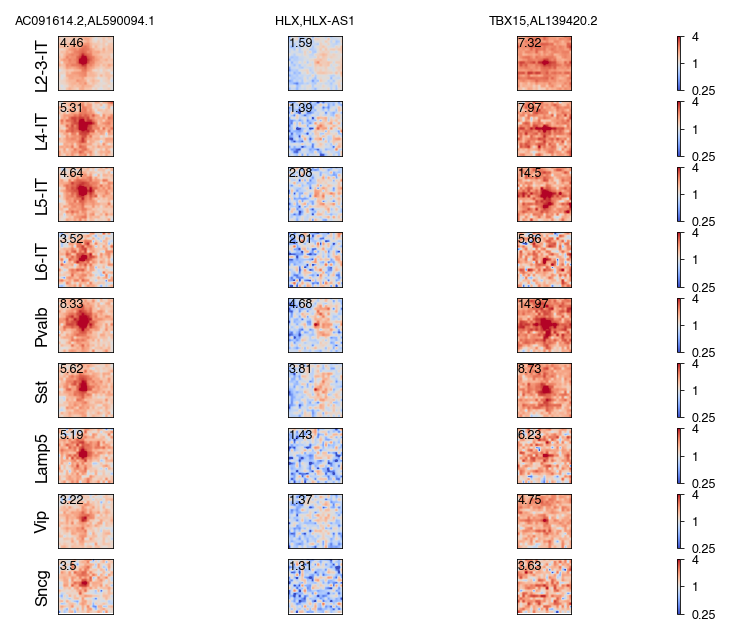

In [270]:
utils.plot_av_dot_2d(stack, 4, dpi=150, figsize=[6, 5])

# H3K27me3 in EN and IN

In [37]:
# Load cluster annotation
dot_clust_path = "/home/nvaulin/wd/tian_polycomb_analysis/Summer2025_restart/polycomb_loop_clusters_update_June25.tsv"
dot_clust = pd.read_csv(dot_clust_path, index_col=0)
cls = dot_clust['cluster_name'].unique()
print(cls)
dot_clust.head()

['Neuron-specific' 'EN-prevalent' 'IN-prevalent' 'Common' 'IN-specific'
 'EN-specific' 'NN-specific']


chrom1    start1      end1 chrom2    start2      end2  \
0   chr1  18630000  18640000   chr1  24930000  24940000   
1   chr1  18630000  18640000   chr1  44410000  44420000   
2   chr1  18630000  18640000   chr1  46480000  46490000   
3   chr1  18630000  18640000   chr1  47180000  47250000   
4   chr1  18630000  18640000   chr1  47430000  47440000   

                                                loop     cluster_name  \
0  (('chr1', 18630000, 18640000), ('chr1', 249300...  Neuron-specific   
1  (('chr1', 18630000, 18640000), ('chr1', 444100...  Neuron-specific   
2  (('chr1', 18630000, 18640000), ('chr1', 464800...  Neuron-specific   
3  (('chr1', 18630000, 18640000), ('chr1', 471800...  Neuron-specific   
4  (('chr1', 18630000, 18640000), ('chr1', 474300...  Neuron-specific   

   cluster_id gene1            gene2  
0           2  PAX7            RUNX3  
1           2  PAX7           RNF220  
2           9  PAX7                -  
3           9  PAX7  TAL1,AL135960.1  
4           2  PAX7  FOXD2,FOXD2-AS1

<Axes: xlabel='gene1'>

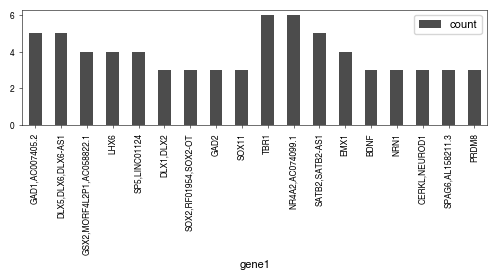

In [68]:
hand_noex_map = hand_anch_flt.drop_duplicates('genes').set_index('genes')['noex']

dif_dots_d = {}
for cl in ['EN-specific', 'IN-specific']:
    dif_dots_d[cl] = dot_clust.loc[dot_clust['cluster_name'] == cl]
    dif_dots_d[cl] = pd.concat([dif_dots_d[cl], dif_dots_d[cl].rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
    dif_dots_d[cl]['noex1'] = dif_dots_d[cl]['gene1'].map(hand_noex_map)
    dif_dots_d[cl]['noex2'] = dif_dots_d[cl]['gene2'].map(hand_noex_map)
    dif_dots_d[cl] = dif_dots_d[cl].loc[dif_dots_d[cl]['noex2'] & 
                                       (dif_dots_d[cl]['noex1'] != True)]
    dif_dots_d[cl] = dif_dots_d[cl]['gene1'].value_counts().to_frame()
    dif_dots_d[cl] = dif_dots_d[cl].loc[dif_dots_d[cl]['count'] > 2]

dif_dots = pd.concat(dif_dots_d.values())
dif_dots.plot(kind='bar', figsize=[6, 1.5], color='k', alpha=0.7)

In [78]:
hand_anch_dif = hand_anch.set_index('genes').loc[dif_dots.index]
hand_anch_dif['length'] = hand_anch_dif['end'] - hand_anch_dif['start']
hand_anch_dif

chrom      start        end  length
gene1                                                         
GAD1,AC007405.2             chr2  170810000  170820000   10000
DLX5,DLX6,DLX6-AS1          chr7   96980000   97040000   60000
GSX2,MORF4L2P1,AC058822.1   chr4   54080000   54120000   40000
LHX6                        chr9  122190000  122230000   40000
SP5,LINC01124               chr2  170710000  170720000   10000
DLX1,DLX2                   chr2  172075000  172115000   40000
SOX2,RF01954,SOX2-OT        chr3  181695000  181730000   35000
GAD2                       chr10   26200000   26220000   20000
SOX11                       chr2    5690000    5700000   10000
TBR1                        chr2  161410000  161430000   20000
NR4A2,AC074099.1            chr2  156315000  156345000   30000
SATB2,SATB2-AS1             chr2  199450000  199480000   30000
EMX1                        chr2   72910000   72920000   10000
BDNF                       chr11   27720000   27730000   10000
NRN1                        chr6    5990000    6010000   20000
CERKL,NEUROD1               chr2  181680000  181690000   10000
SPAG6,AL158211.3           chr10   22320000   22350000   30000
PRDM8                       chr4   80185000   80220000   35000

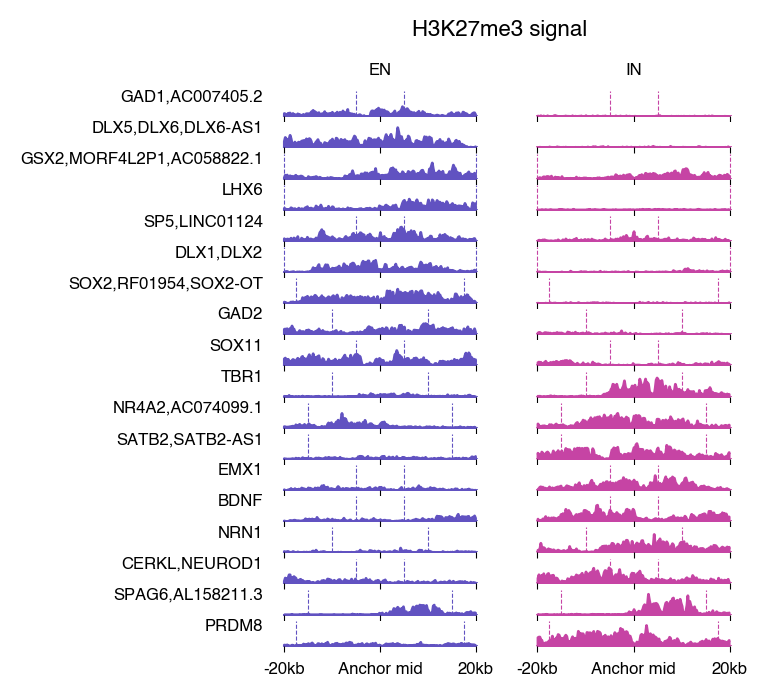

In [80]:
import bbi


offset, nbins = 20_000, 200
bp_per_bin = 2 * offset / nbins
# plot_df = dif_dot_tss.copy(deep=True)
plot_df = hand_anch_dif.copy(deep=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start_mid'] = plot_df['mid'] - offset
plot_df['end_mid'] = plot_df['mid'] + offset

fig, axs = plt.subplots(plot_df.shape[0], len(me3_path), dpi=200, 
                        figsize=[1.5 * len(me3_path), 0.2 * plot_df.shape[0]], 
                        sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.25)

for j, (name, path) in enumerate(me3_path.items()):
    
    s = bbi.stackup(path, plot_df['chrom'], plot_df['start_mid'], plot_df['end_mid'], bins=nbins)
    # s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
    
    for i, gene in enumerate(plot_df.index):
        ax = axs[i, j] 
#         ax.plot(np.arange(nbins), s[i, :])
        ax.plot([0, nbins], [0, 0], linewidth=1, c=palette[name])
        ax.fill_between(np.arange(nbins), [0]*nbins, s[i, :], color=palette[name])
        ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
        ax.set_ylim([0, 0.75])
        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'Anchor mid', f"{offset//1000}kb"])
        ax.set_yticks([])
        reg_start, reg_start_mid = plot_df.loc[gene, 'start'], plot_df.loc[gene, 'start_mid']
        reg_end, reg_end_mid = plot_df.loc[gene, 'end'], plot_df.loc[gene, 'end_mid']
        if reg_start >= reg_start_mid:
            reg_start_x = (reg_start - reg_start_mid) / bp_per_bin
            reg_end_x = nbins - reg_start_x
            ax.axvline(reg_start_x, c=palette[name], ls='--')
            ax.axvline(reg_end_x, c=palette[name], ls='--')
#         ax.set_yticklabels([])
        
    
        if j == 0:
            ax.set_ylabel(gene, rotation='horizontal', ha='right', fontsize=6)
        if i == 0:
            ax.set_title(name, fontsize=6)
    
plt.suptitle('H3K27me3 signal', fontsize=8)  
plt.savefig('H3k27me3_cluster_spec_anchors.pdf', bbox_inches='tight')